In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 9.5 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 211, done.
remote: Counting objects:

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-151b9d639ad9>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.9,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "batch_size": 32,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [10]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [11]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [12]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

In [13]:
# test model 
sample_input = torch.randn((32, 120, 42))
model = IMUEncoder(in_ft=42, d_model=128, num_heads=2, ft_size=128, n_classes=2, max_len=120, dropout=0.1)
sample_output = model(sample_input)
sample_output.shape

torch.Size([32, 128])

---

In [14]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [16]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [17]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [18]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        cls:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="mean")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    # print("selected featues > ", selected_features.shape, "y_pred > ", y_pred.shape)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,cls)
    #print(loss)
    return loss

def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

def predict_class(
        y_pred:torch.Tensor,
        selected_features):

    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(torch.abs(F.cosine_similarity(entry.repeat(num_classes,1),selected_features)),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [19]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [20]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [21]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [22]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [25]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [23]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-23-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-90


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.779



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.896



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.835



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.915



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.927



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.959



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.944



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.964



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.766



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.972



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.975



train:   0%|          | 0/284 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.987



unseen:   0%|          | 0/84 [00:00<?, ?batch/s]

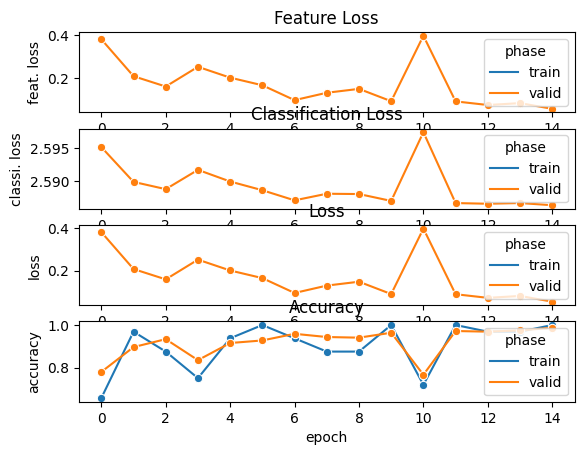

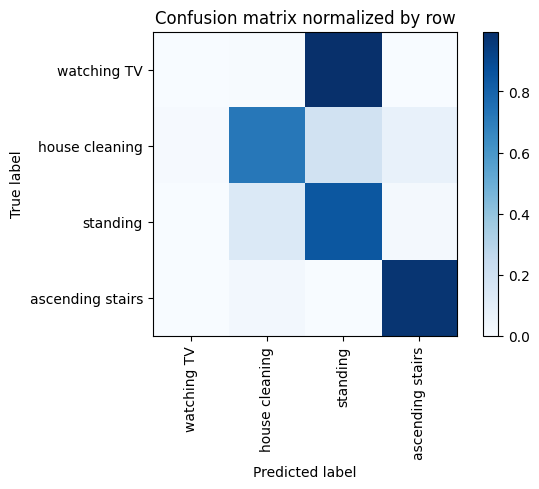

Overall accuracy: 0.699

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.826      0.723      0.771      0.336        902|	 standing: 0.188,	ascending stairs: 0.078,	
        standing       0.567      0.846      0.679      0.333        895|	 house cleaning: 0.137,	ascending stairs: 0.016,	
ascending stairs       0.848      0.975      0.907      0.179        481|	 house cleaning: 0.025,	standing: 0.000,	
     watching TV       0.000      0.000      0.000      0.153        410|	 standing: 0.995,	house cleaning: 0.005,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.618      0.699      0.647        1.0       2688|	      

{'accuracy': 0.6986607142857143, 'precision': 0.5603762371204546, 'recall': 0.6359250420975451, 'f1': 0.5893054441043872, 'samples': 2688, 'loss': 3072.021381378174, 'feat. loss': 3071.660243988037, '

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.850



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.848



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.879



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.886



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.852



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.799



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.889



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.874



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.927



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.905



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.897



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.902



train:   0%|          | 0/286 [00:00<?, ?batch/s]

seen:   0%|          | 0/31 [00:00<?, ?batch/s]

Overall accuracy: 0.921



unseen:   0%|          | 0/82 [00:00<?, ?batch/s]

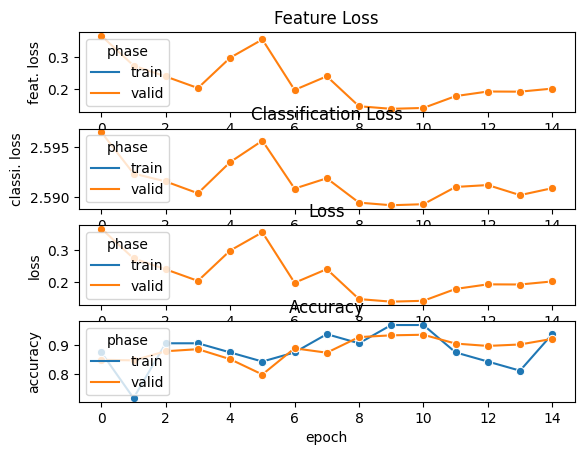

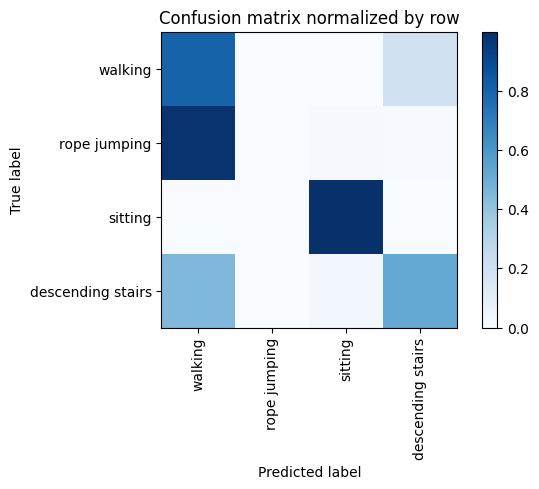

Overall accuracy: 0.759

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.698      0.802      0.747      0.432       1134|	 descending stairs: 0.197,	sitting: 0.001,	
          sitting       0.983      0.999      0.991      0.331        868|	 walking: 0.001,	descending stairs: 0.000,	
descending stairs       0.489      0.521      0.504      0.157        411|	 walking: 0.450,	sitting: 0.029,	
     rope jumping       0.000      0.000      0.000      0.080        211|	 walking: 0.986,	sitting: 0.009,	descending stairs: 0.005,	

----------------------------------------------------------------------------------------------------
      avg / total       0.703      0.759      0.729        1.0       2624|	      

{'accuracy': 0.758765243902439, 'precision': 0.5423576082252382, 'recall': 0.5804995818191407, 'f1': 0.5603732938993724, 'samples': 2624, 'loss': 2677.859266281128, 'feat. loss': 2677.5145149230957, 'classi. loss': 

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.628



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.817



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.857



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.876



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.897



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.928



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.858



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.933



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.904



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.871



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.904



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/262 [00:00<?, ?batch/s]

seen:   0%|          | 0/29 [00:00<?, ?batch/s]

Overall accuracy: 0.820



unseen:   0%|          | 0/108 [00:00<?, ?batch/s]

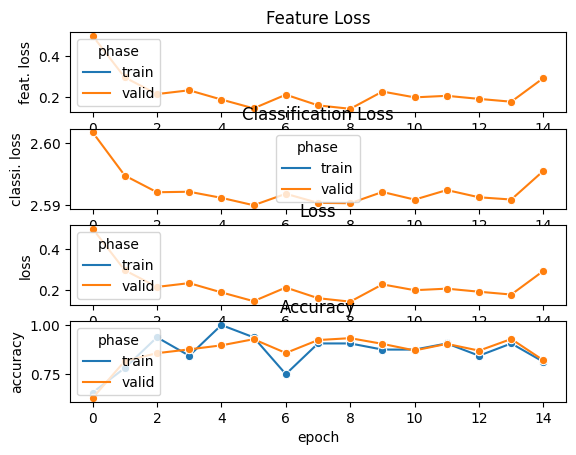

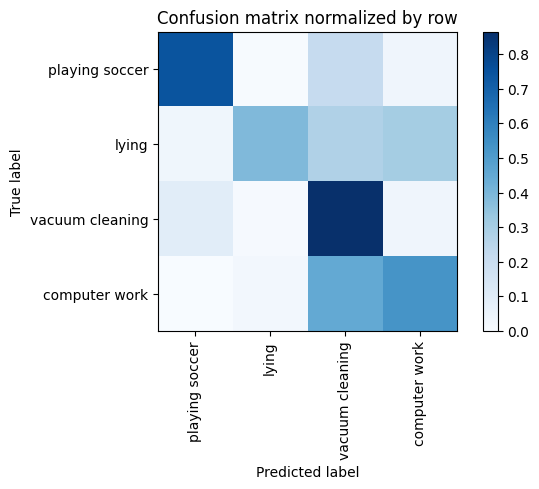

Overall accuracy: 0.584

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.717      0.528      0.608      0.438       1514|	 vacuum cleaning: 0.450,	lying: 0.022,	
          lying       0.897      0.387      0.541      0.262        905|	 computer work: 0.306,	vacuum cleaning: 0.276,	
vacuum cleaning       0.419      0.864      0.565      0.237        818|	 playing soccer: 0.092,	computer work: 0.037,	
 playing soccer       0.613      0.744      0.672      0.063        219|	 vacuum cleaning: 0.215,	computer work: 0.037,	

----------------------------------------------------------------------------------------------------
    avg / total       0.687      0.584      0.584        1.0       3456|	      

{'accuracy': 0.5842013888888888, 'precision': 0.661697186661391, 'recall': 0.630769207660498, 'f1': 0.5963672364244554, 'samples': 3456, 'loss': 4067.387565612793, 'feat. loss': 4066.9248542785645, 'classi. loss': 4627.1324424

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.621



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.796



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.834



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.848



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.865



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.850



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.897



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.848



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.774



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.946



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.910



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.931



train:   0%|          | 0/300 [00:00<?, ?batch/s]

seen:   0%|          | 0/33 [00:00<?, ?batch/s]

Overall accuracy: 0.875



unseen:   0%|          | 0/66 [00:00<?, ?batch/s]

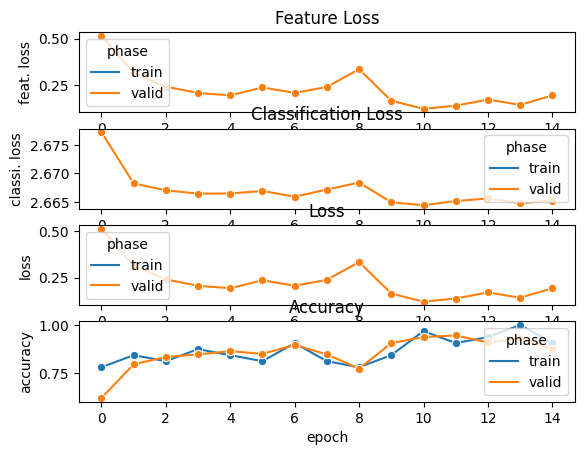

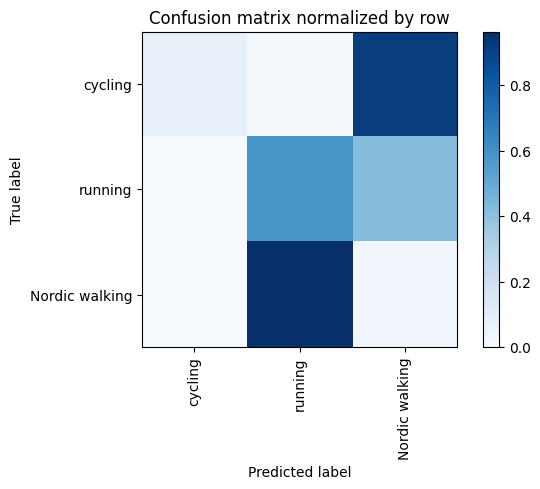

Overall accuracy: 0.166

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.030      0.032      0.031      0.420        886|	 running: 0.963,	cycling: 0.006,	
       cycling       0.922      0.076      0.141      0.366        774|	 Nordic walking: 0.913,	running: 0.010,	
       running       0.234      0.582      0.334      0.214        452|	 Nordic walking: 0.418,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.401      0.166      0.136        1.0       2112|	      

{'accuracy': 0.16571969696969696, 'precision': 0.3953879318091951, 'recall': 0.2298961686880454, 'f1': 0.16850234251475246, 'samples': 2112, 'loss': 3576.210334777832, 'feat. loss': 3575.978675842285, 'classi. loss': 2316.5423545837402, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1,

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.722



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.814



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.858



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.899



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.903



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.897



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.942



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.832



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.895



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.932



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.939



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.923



train:   0%|          | 0/307 [00:00<?, ?batch/s]

seen:   0%|          | 0/34 [00:00<?, ?batch/s]

Overall accuracy: 0.932



unseen:   0%|          | 0/58 [00:00<?, ?batch/s]

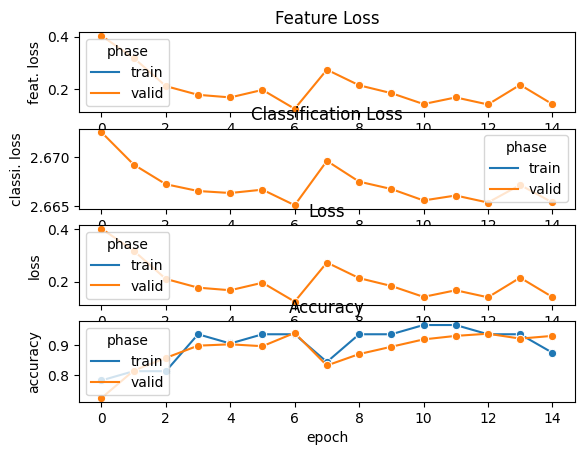

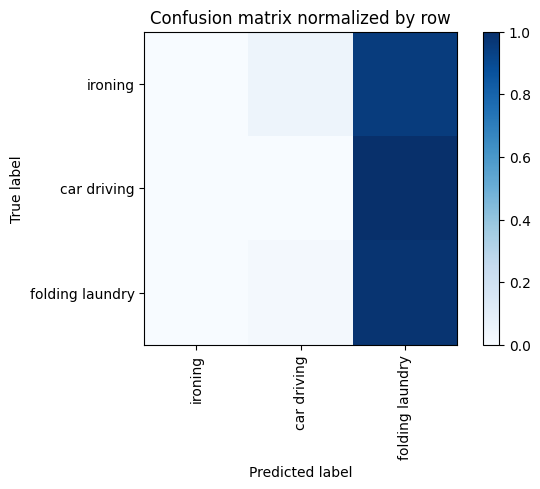

Overall accuracy: 0.248

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.606       1125|	 folding laundry: 0.951,	car driving: 0.049,	
folding laundry       0.257      0.981      0.407      0.253        469|	 car driving: 0.019,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.141        262|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.065      0.248      0.103        1.0       1856|	      

{'accuracy': 0.2478448275862069, 'precision': 0.08556547619047618, 'recall': 0.3269367448471926, 'f1': 0.13563320064868054, 'samples': 1856, 'loss': 3265.4091415405273, 'feat. loss': 3265.207229614258, 'classi. loss': 2019.1595077514648, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.522622
precision    0.472255
r

In [26]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
